In [1]:
import cv2
from PIL import Image
import random
import os, glob
import numpy as np
import matplotlib.pyplot as plt

In [3]:
data = []
labels = []
div_data = []

height = 128
width = 128
channels = 3
num_classes = 3

path = f'Linnaeus 5 128X128/train/'
Class = os.listdir(path)
print(Class)
for i, a in enumerate(Class):
    data_path = f'Linnaeus 5 128X128/train/{a}/'
    data_list = os.listdir(data_path)
    for d in data_list:
        image = cv2.imread(data_path + d)
        image_from_array = Image.fromarray(image, 'RGB')
        img_arr = np.array(image_from_array)
        div_data.append(divide_image(image=img_arr))
        data.append(img_arr)
        labels.append(i)

data = np.array(data)
labels = np.array(labels)

['dog', 'bird', 'flower']


In [4]:
## test
test_data = []
test_labels = []
div_test_data = []

height = 128
width = 128
channels = 3
num_classes = 3

path = f'Linnaeus 5 128X128/test/'
Class = os.listdir(path)
print(Class)
for i, a in enumerate(Class):
    data_path = f'Linnaeus 5 128X128/test/{a}/'
    data_list = os.listdir(data_path)
    for d in data_list:
        image = cv2.imread(data_path + d)
        image_from_array = Image.fromarray(image, 'RGB')
        img_arr = np.array(image_from_array)
        div_test_data.append(divide_image(image=img_arr))
        test_data.append(img_arr)
        test_labels.append(i)

test_data = np.array(test_data)
test_labels = np.array(test_labels)

['dog', 'bird', 'flower']


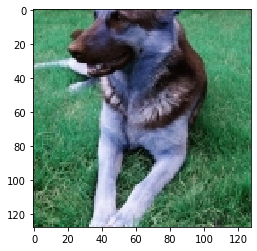

In [5]:
plt.imshow(test_data[0])

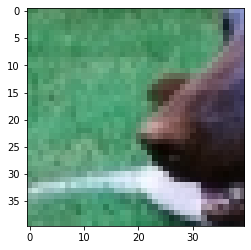

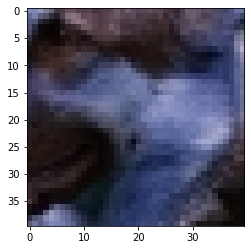

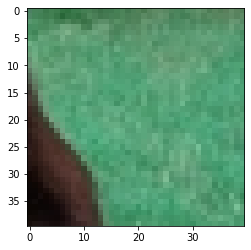

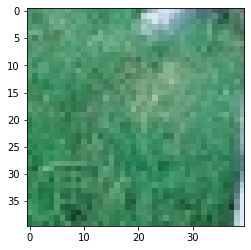

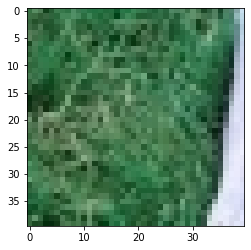

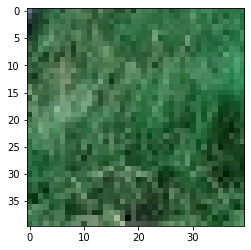

In [6]:
for im in np.array(div_test_data[0]):
    plt.figure()
    plt.imshow(im)


In [14]:
def reconstruct_image(combined_blocks):
    rows = []
    for i in range(0, 18, 3):
        row = np.concatenate(combined_blocks[i:i+3], axis=0)
        rows.append(row)
    merged_image = np.concatenate(rows, axis=1)
    return merged_image

def shuffle_blocks(blocks_a, blocks_b, l1, l2):
    shf_blocks = []
    mix_blocks = []
    mix_labels = []
    a_labels = [l1]*9
    b_labels = [l2]*9
    
    for b_a, b_b in zip(blocks_a, blocks_b):
        a_data = list(zip(b_a, a_labels))
        b_data = list(zip(b_b, b_labels))
        
        random.shuffle(a_data)
        random.shuffle(b_data)
        b_a_sh, b_a_label = zip(*a_data)
        b_b_sh, b_b_label = zip(*b_data)
        
        mixed_sub_block = b_a_sh + b_b_sh
        mixed_sub_labels = b_a_label + b_b_label
        
        mixed_sub_blocks = list(zip(mixed_sub_block, mixed_sub_labels))
        random.shuffle(mixed_sub_blocks)
        
        mixed_data, mixed_label = zip(*mixed_sub_blocks)
        mix_blocks.append(mixed_data)
        
        mix_labels.append(mixed_label)
        shf_blocks.append(reconstruct_image(mixed_sub_block))
    return shf_blocks, mix_blocks, mix_labels

In [15]:
def mk_shuffle_data(divided_data, d_size):
    
    label_idx = [0, d_size*1, d_size*2] 
    label_dict = {l : i for i, l in enumerate(label_idx)}
    shf_labels = []
    shf_datas = []
    mixed_blocks = []
    mixed_labels = []

    for i, l_i in enumerate(label_idx):
        class1 = divided_data[l_i : l_i+d_size]

        for j, l_i2 in enumerate(label_idx[i+1:]):
            if l_i == l_i2:
                continue
            class2 = divided_data[l_i2: l_i2+d_size]
            labels_list = [[l_i//d_size, l_i2//d_size]]* d_size
            shf_labels.append(labels_list)
            recon_block, mixed_blcok, mixed_label =shuffle_blocks(class1, class2, label_dict[l_i], label_dict[l_i2])
            shf_datas.append(recon_block)
            mixed_blocks.append(mixed_blcok)
            mixed_labels.append(mixed_label)
            
    return shf_datas, shf_labels, mixed_blocks, mixed_labels

In [16]:
target_shf_datas, target_shf_labels, mixed_blocks, mixed_labels = mk_shuffle_data(divided_data=div_test_data, d_size=test_data.shape[0]//3)

In [10]:
np.array(target_shf_datas).shape

(3, 400, 120, 240, 3)

In [11]:
np.array(target_shf_labels).shape

(3, 400, 2)

In [17]:
shf_target_arr = np.array(target_shf_datas).reshape(-1,120, 240,3)
shf_target_label = np.array(target_shf_labels).reshape(-1,2)
mixed_target_arr = np.array(mixed_blocks).reshape(-1,18,40,40,3)
mixed_target_label = np.array(mixed_labels).reshape(-1,18)

print(shf_target_arr.shape, shf_target_label.shape, mixed_target_arr.shape, mixed_target_label.shape)

(1200, 120, 240, 3) (1200, 2) (1200, 18, 40, 40, 3) (1200, 18)


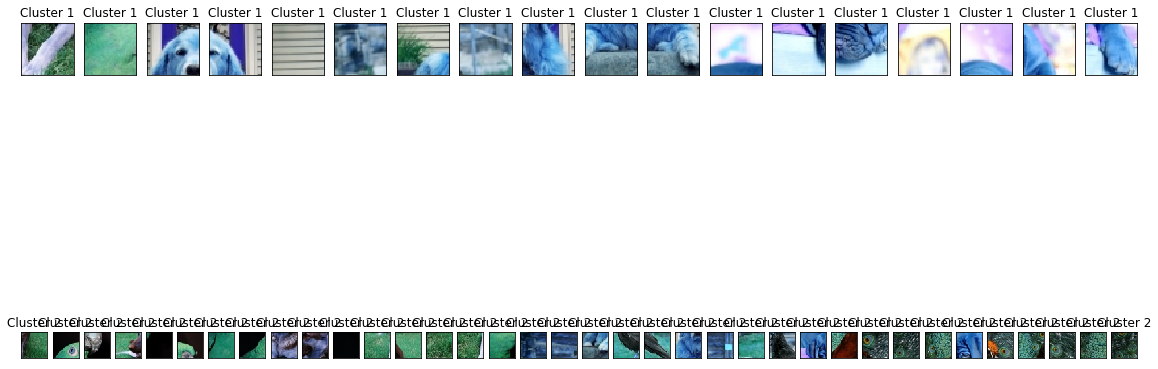

In [20]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

def cluster_dataset(dataset):
    reshaped_dataset = dataset.reshape(-1, 40, 40, 3)
    flattened_dataset = reshaped_dataset.reshape(-1, 40 * 40 * 3)

    kmeans = KMeans(n_clusters=2, random_state=0)
    labels = kmeans.fit_predict(flattened_dataset)

    clusters = [[] for _ in range(2)]
    for i, label in enumerate(labels):
        clusters[label].append(reshaped_dataset[i])

    return clusters

def visualize_clusters(clusters):
    plt.figure(figsize=(20, 10))
    num_clusters = len(clusters)

    for i, cluster in enumerate(clusters):
        for j, image in enumerate(cluster):
            plt.subplot(num_clusters, len(cluster), i * len(cluster) + j + 1)
            plt.imshow(image)
            plt.xticks([])
            plt.yticks([])
            plt.title(f'Cluster {i+1}')

#     plt.tight_layout()
    plt.show()

dataset = mixed_target_arr[:3]


# 데이터셋에 대한 클러스터링 수행
clusters = cluster_dataset(dataset)

# 클러스터링 결과 시각화
visualize_clusters(clusters)


Acc : 4 / 18


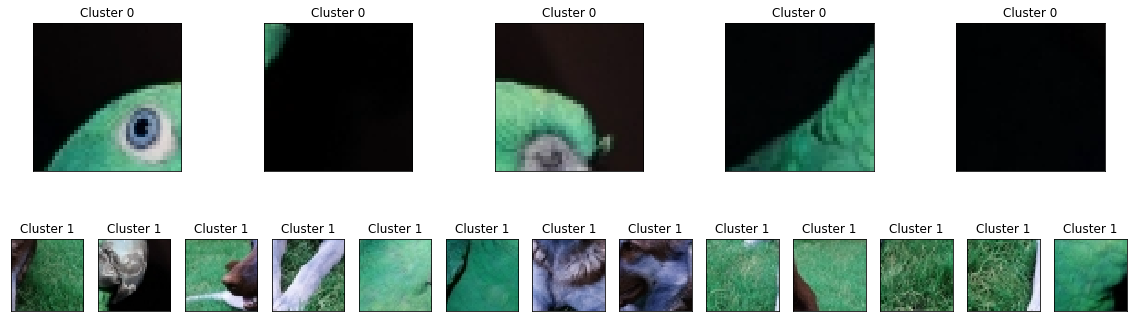

<Figure size 1440x432 with 0 Axes>

Acc : 14 / 18


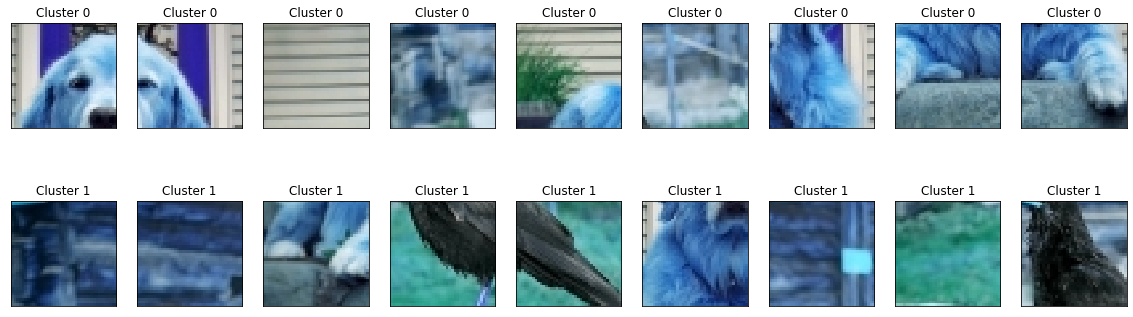

<Figure size 1440x432 with 0 Axes>

Acc : 2 / 18


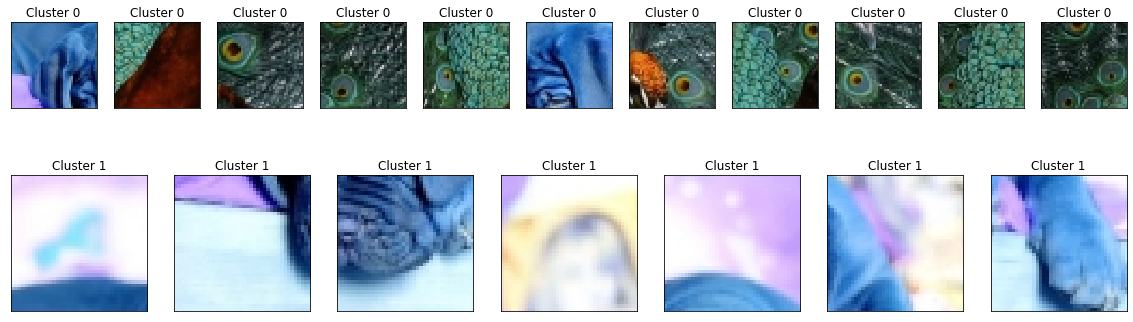

<Figure size 1440x432 with 0 Axes>

Acc : 7 / 18


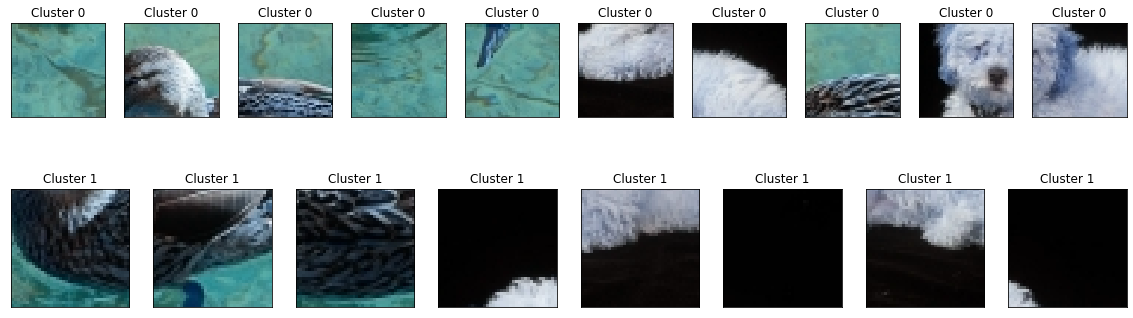

<Figure size 1440x432 with 0 Axes>

Acc : 15 / 18


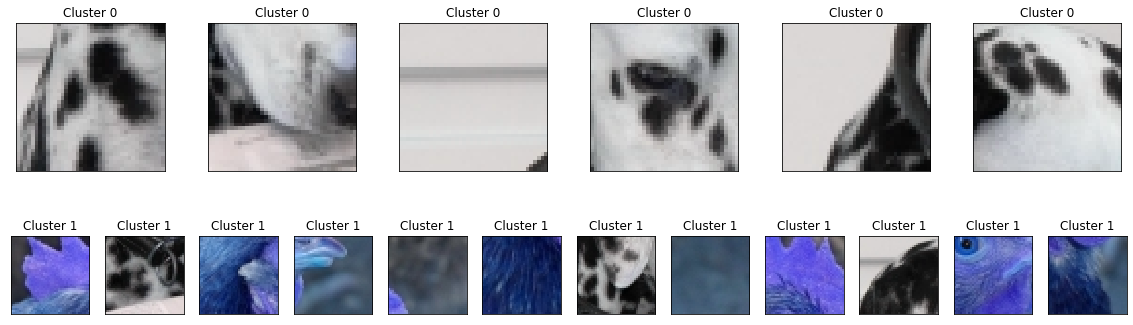

<Figure size 1440x432 with 0 Axes>

Acc : 3 / 18


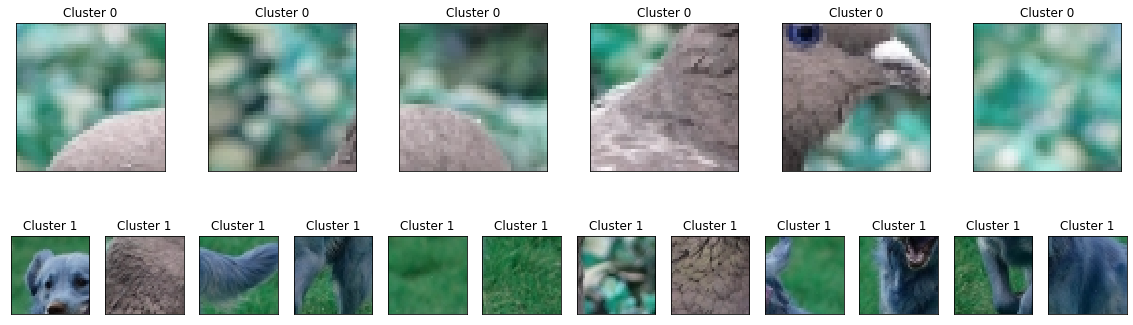

<Figure size 1440x432 with 0 Axes>

Acc : 5 / 18


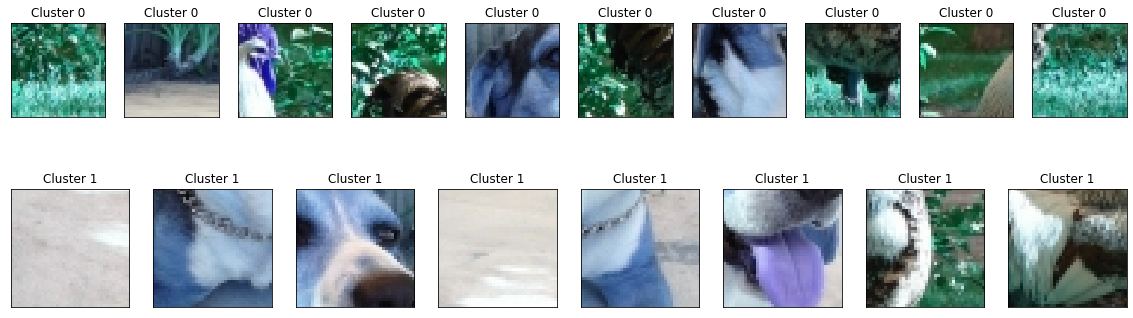

<Figure size 1440x432 with 0 Axes>

Acc : 8 / 18


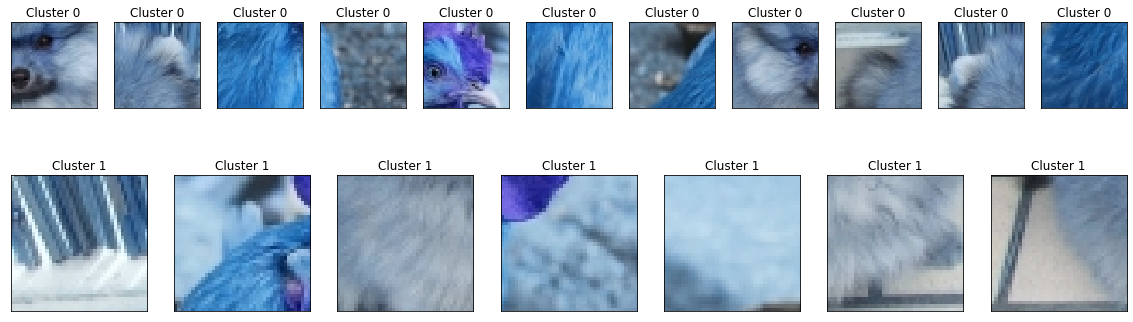

<Figure size 1440x432 with 0 Axes>

Acc : 5 / 18


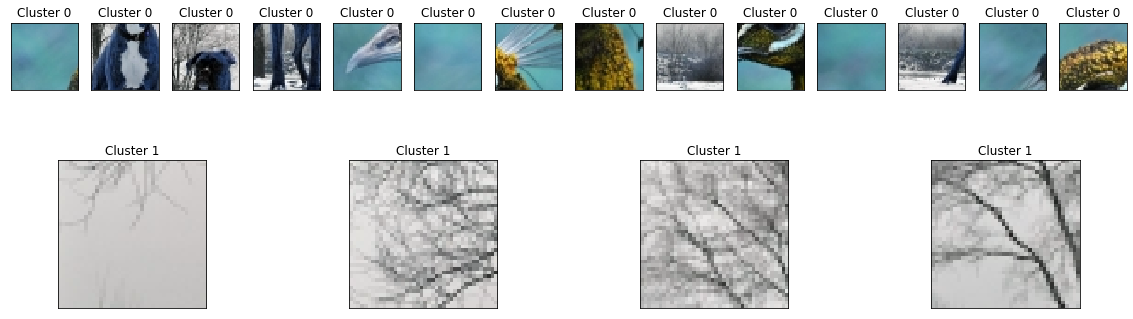

<Figure size 1440x432 with 0 Axes>

Acc : 4 / 18


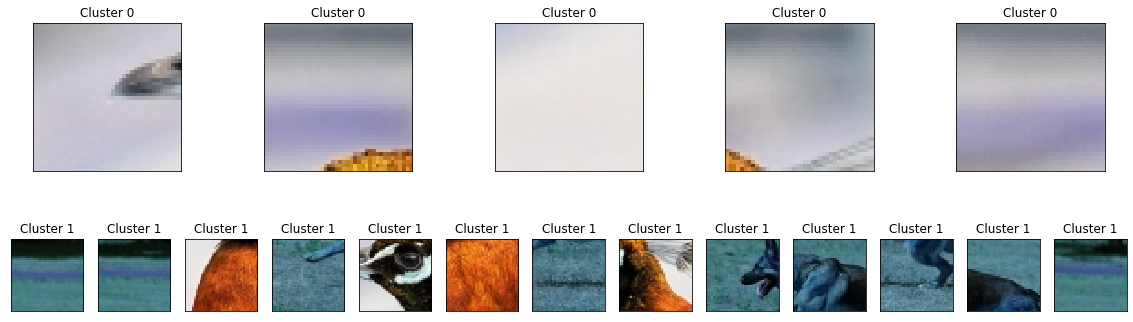

<Figure size 1440x432 with 0 Axes>

Acc : 10 / 18


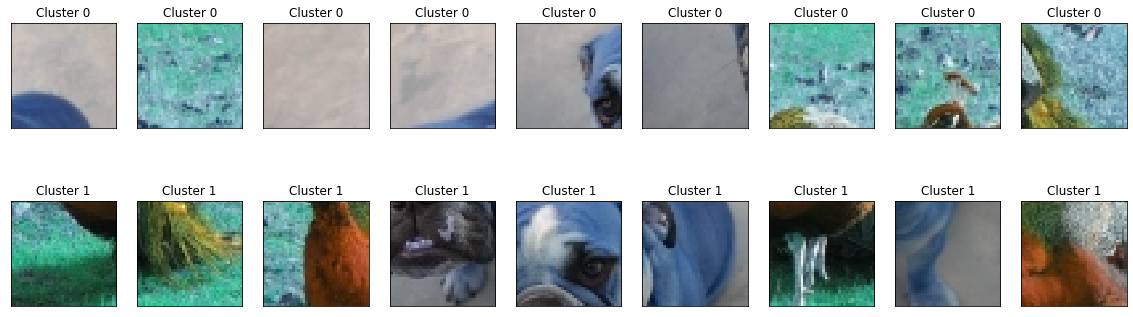

<Figure size 1440x432 with 0 Axes>

Acc : 3 / 18


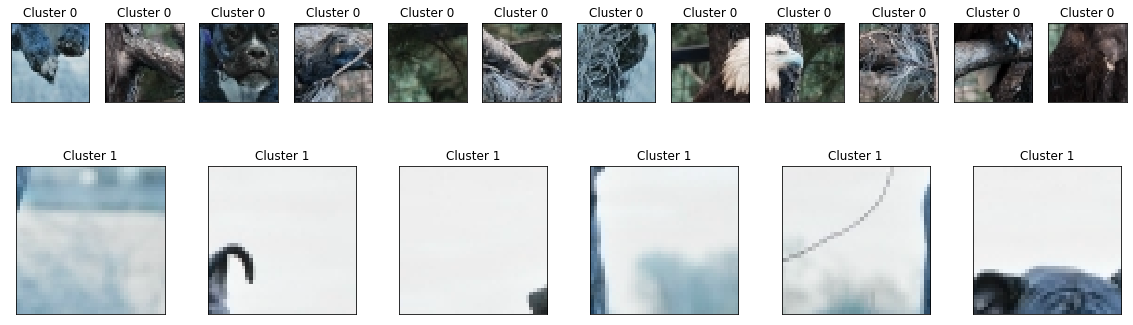

<Figure size 1440x432 with 0 Axes>

Acc : 3 / 18


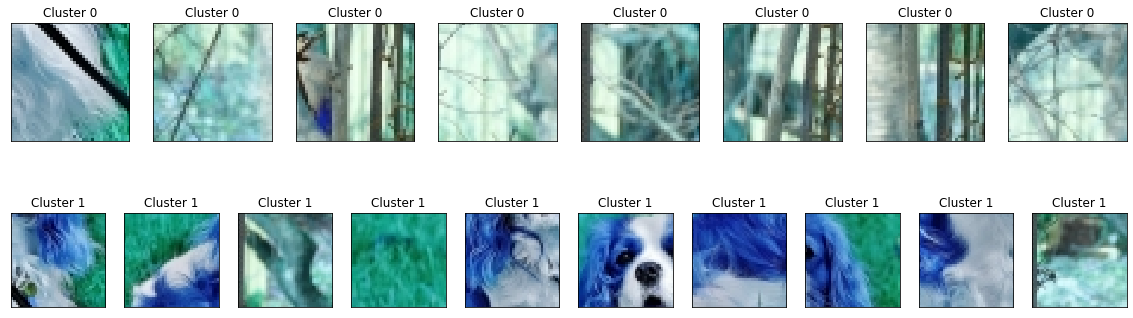

<Figure size 1440x432 with 0 Axes>

Acc : 4 / 18


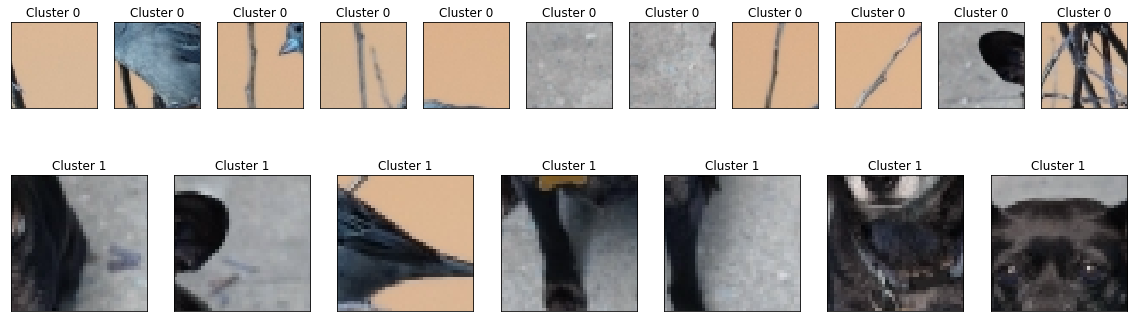

<Figure size 1440x432 with 0 Axes>

Acc : 5 / 18


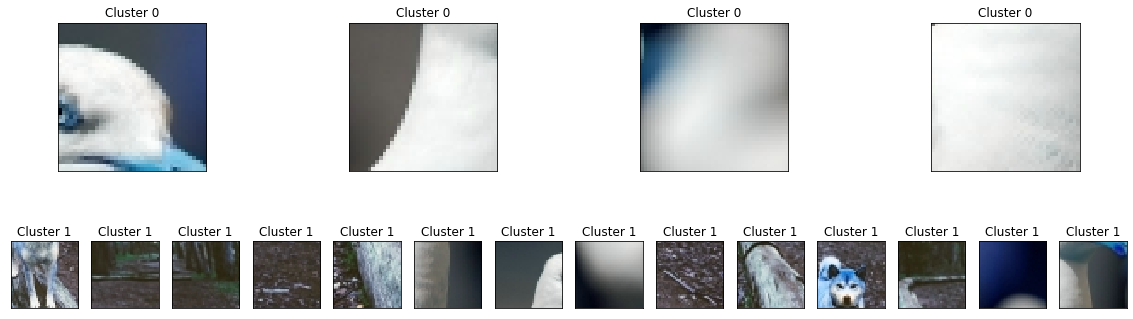

<Figure size 1440x432 with 0 Axes>

Acc : 13 / 18


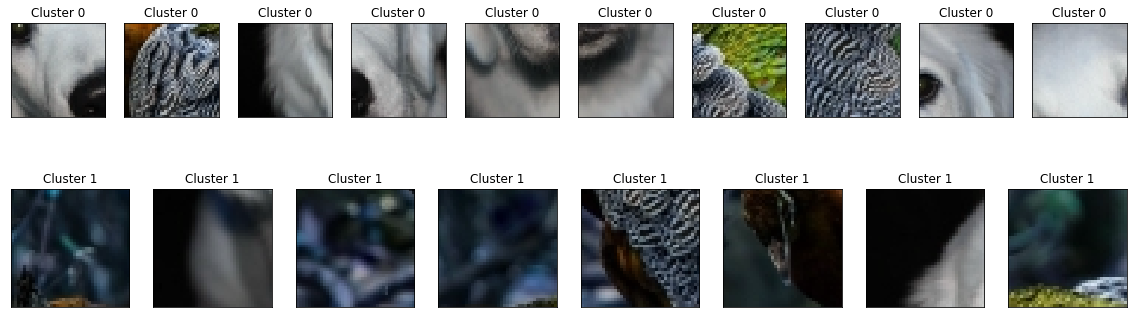

<Figure size 1440x432 with 0 Axes>

Acc : 17 / 18


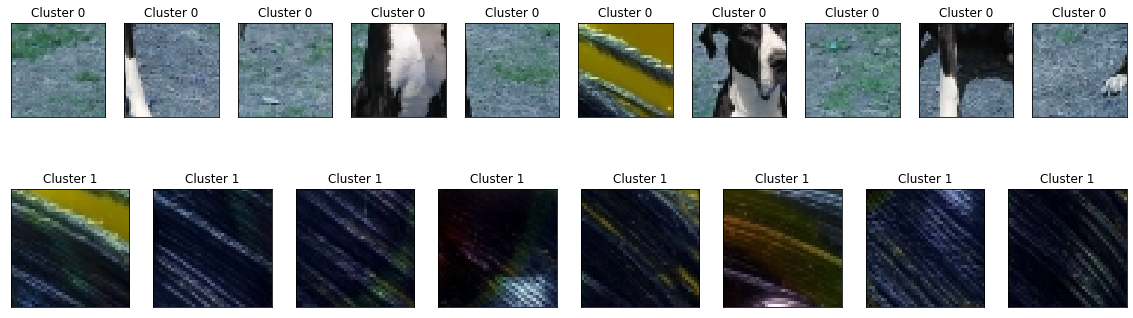

<Figure size 1440x432 with 0 Axes>

Acc : 0 / 18


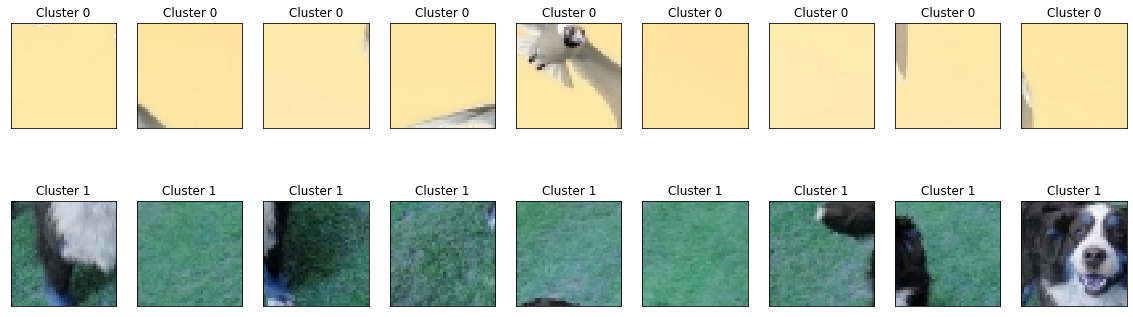

<Figure size 1440x432 with 0 Axes>

Acc : 11 / 18


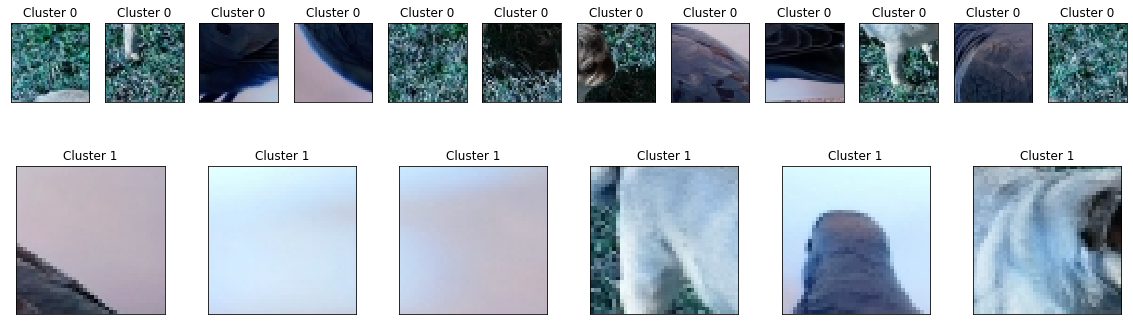

<Figure size 1440x432 with 0 Axes>

Acc : 3 / 18


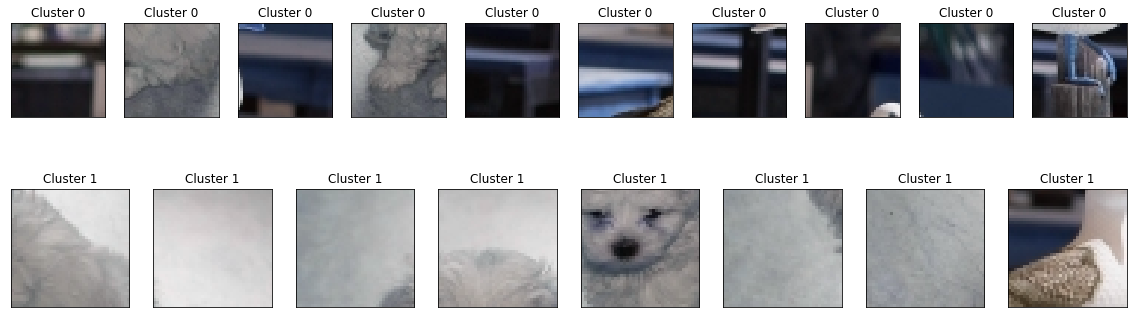

<Figure size 1440x432 with 0 Axes>

Acc : 7 / 18


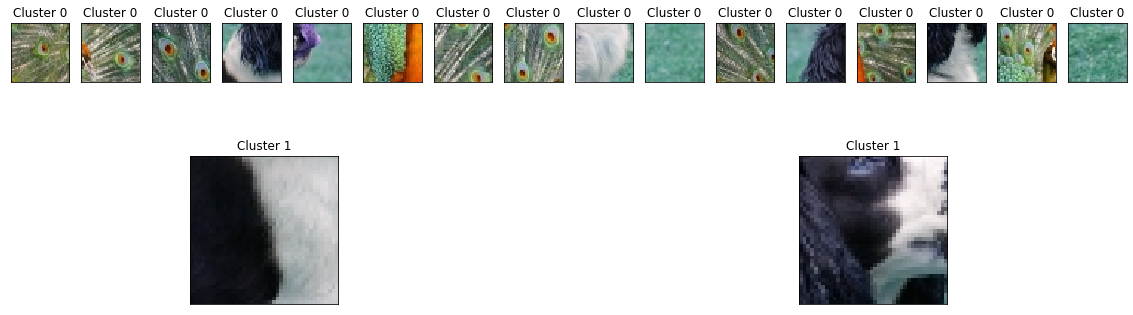

<Figure size 1440x432 with 0 Axes>

Acc : 17 / 18


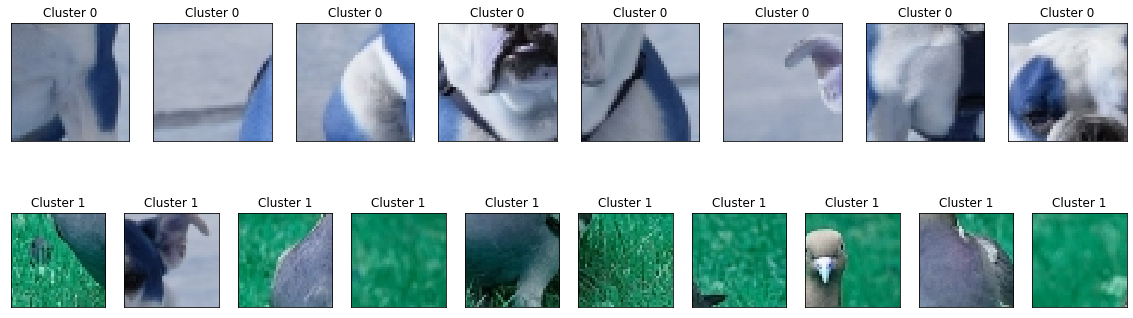

<Figure size 1440x432 with 0 Axes>

Acc : 15 / 18


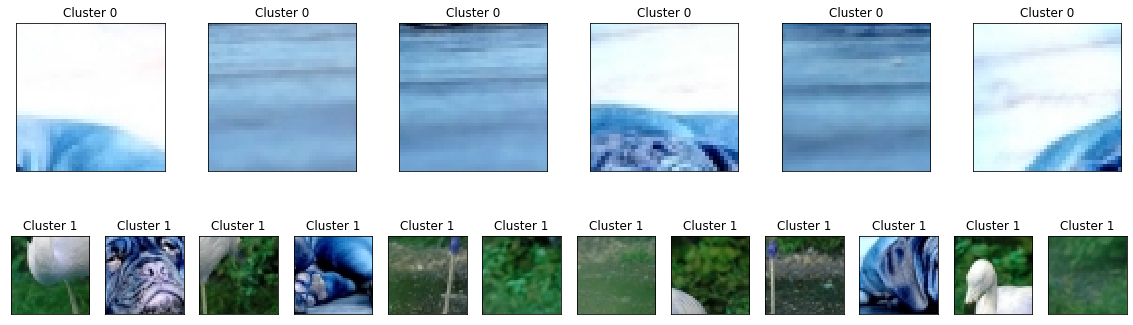

<Figure size 1440x432 with 0 Axes>

Acc : 0 / 18


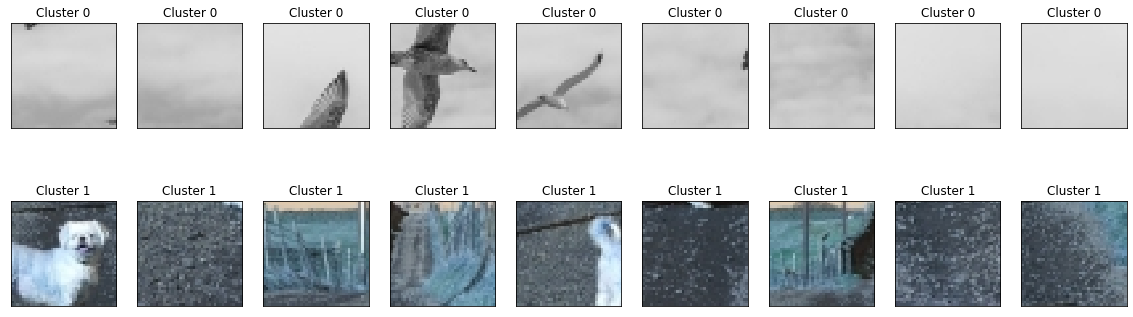

<Figure size 1440x432 with 0 Axes>

Acc : 12 / 18


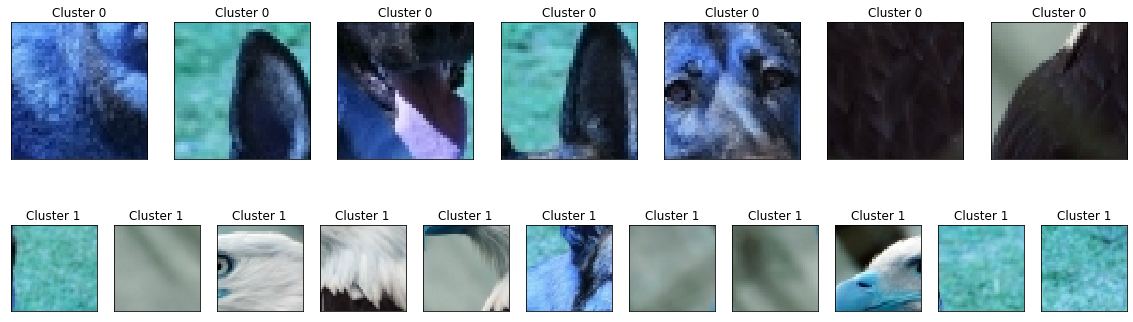

<Figure size 1440x432 with 0 Axes>

Acc : 15 / 18


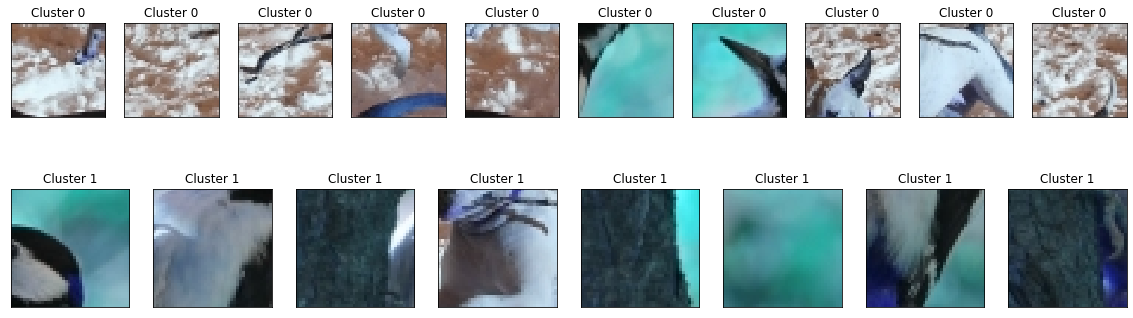

<Figure size 1440x432 with 0 Axes>

Acc : 9 / 18


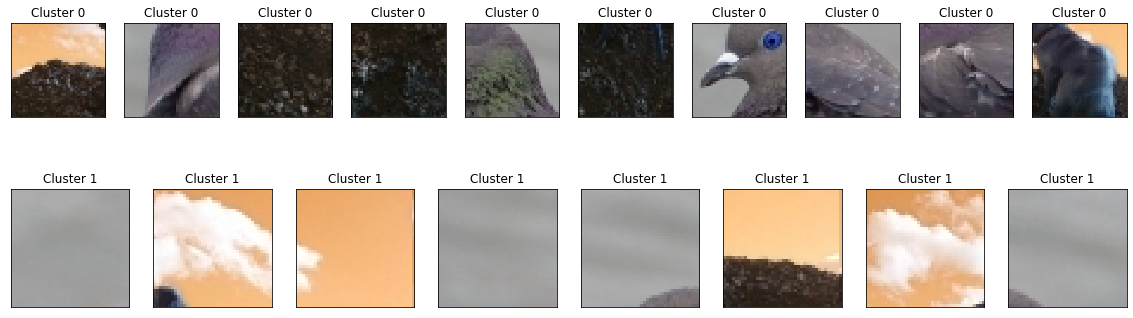

<Figure size 1440x432 with 0 Axes>

Acc : 6 / 18


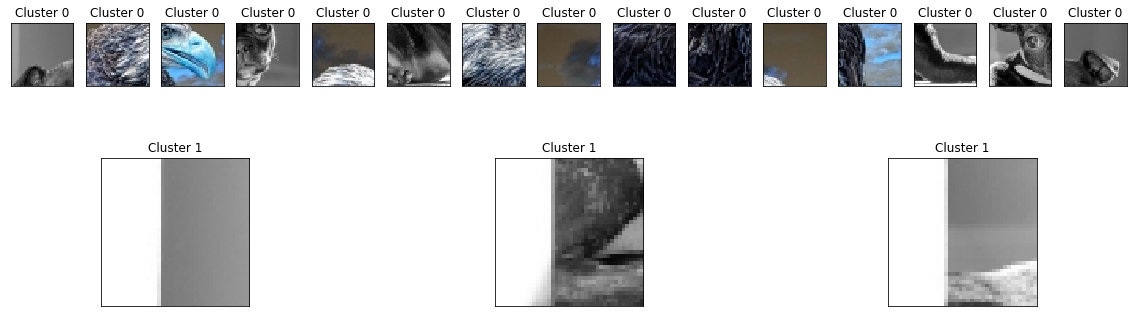

<Figure size 1440x432 with 0 Axes>

Acc : 8 / 18


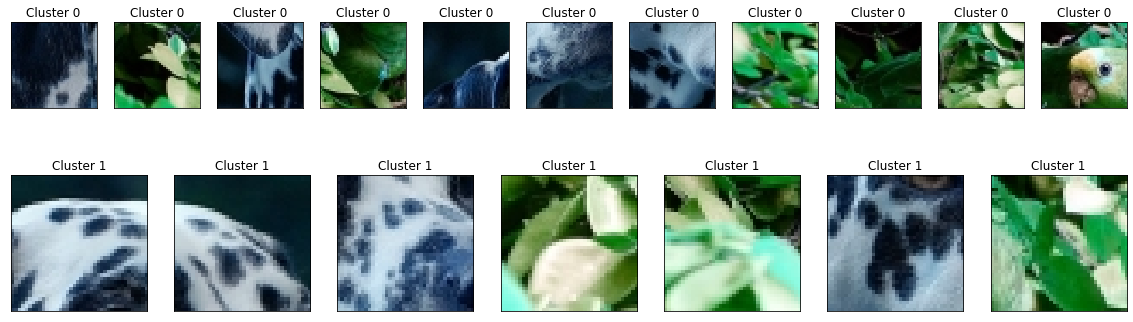

<Figure size 1440x432 with 0 Axes>

Acc : 16 / 18


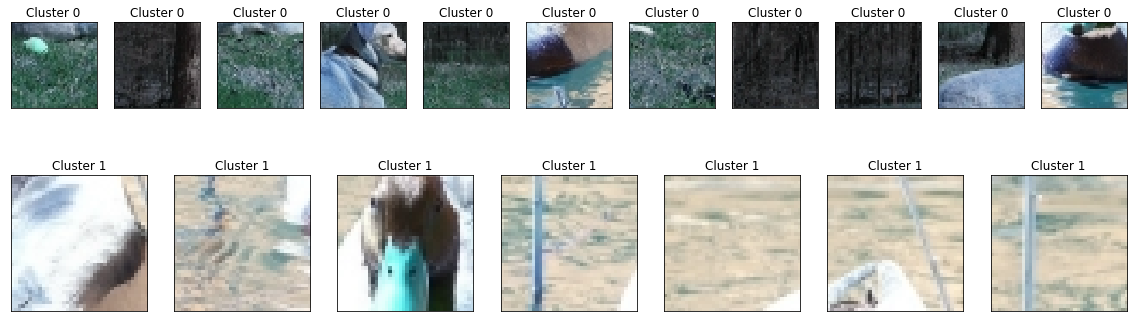

<Figure size 1440x432 with 0 Axes>

Acc : 6 / 18


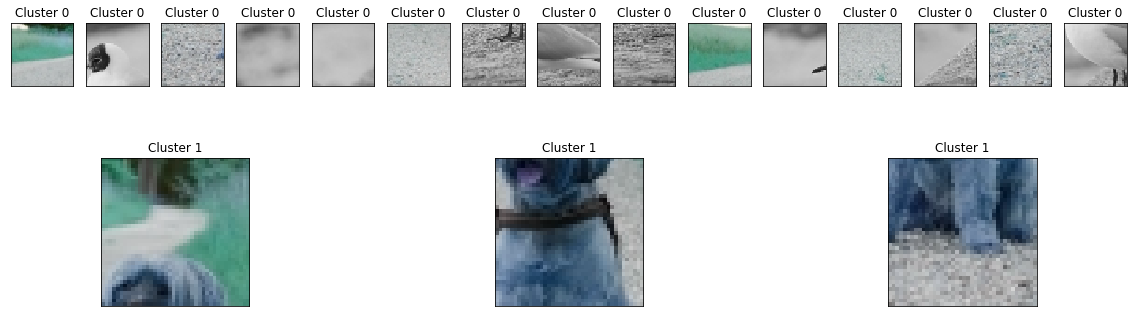

<Figure size 1440x432 with 0 Axes>

Acc : 12 / 18


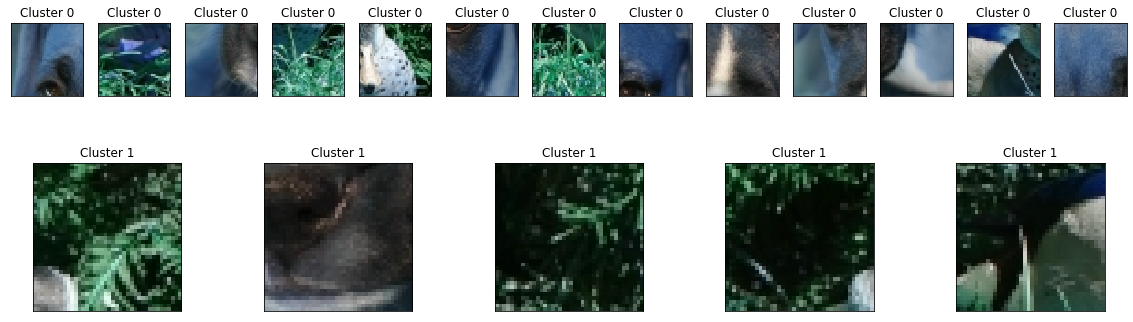

<Figure size 1440x432 with 0 Axes>

Acc : 18 / 18


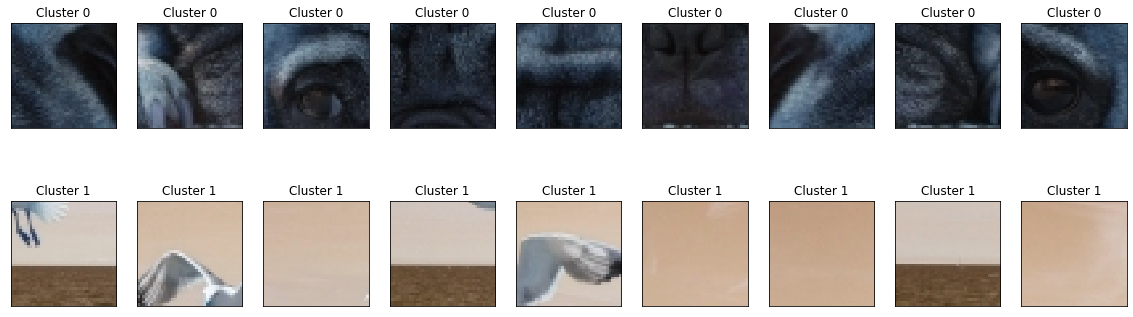

<Figure size 1440x432 with 0 Axes>

Acc : 8 / 18


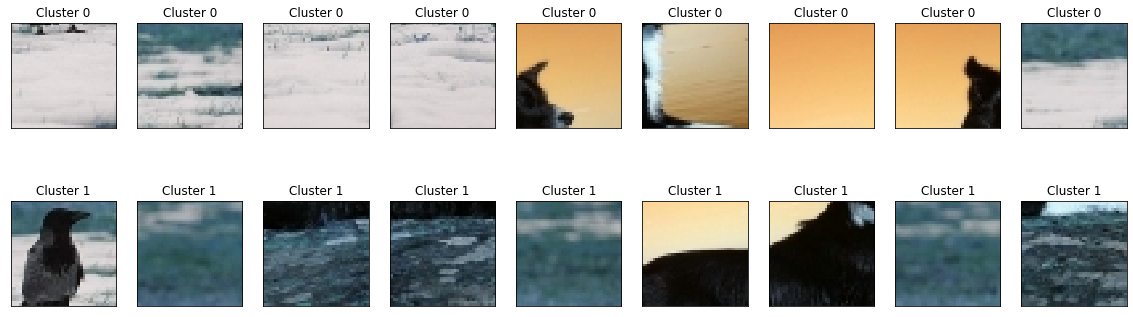

<Figure size 1440x432 with 0 Axes>

Acc : 12 / 18


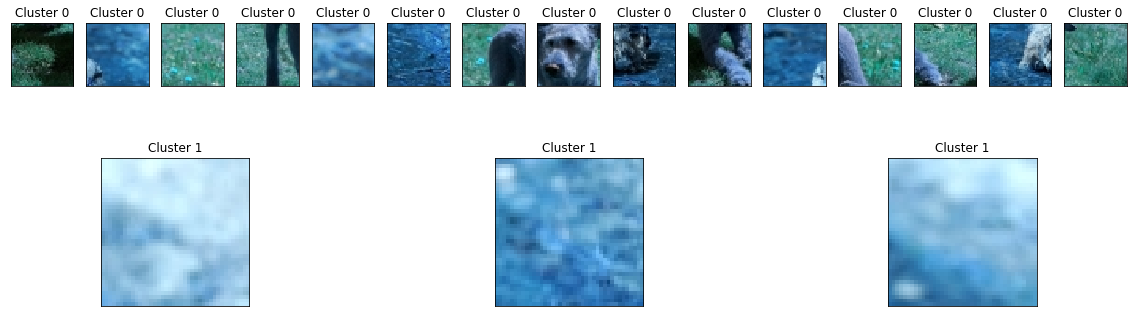

<Figure size 1440x432 with 0 Axes>

Acc : 14 / 18


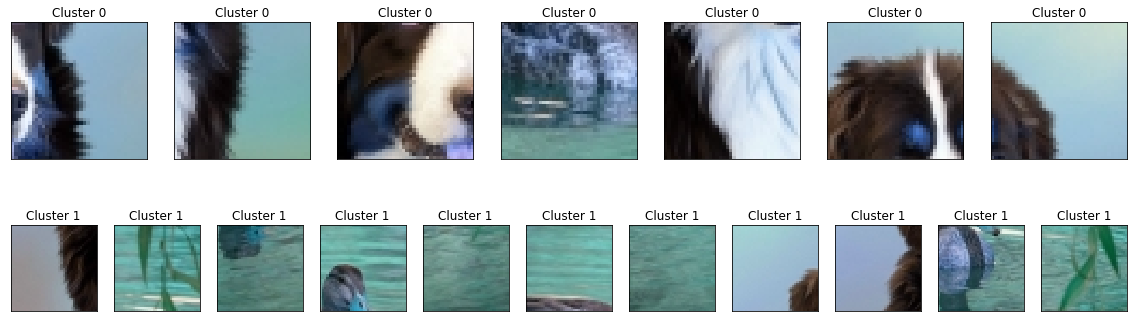

<Figure size 1440x432 with 0 Axes>

Acc : 11 / 18


KeyboardInterrupt: 

In [32]:
import cv2
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

def cluster_blocks(sub_blocks, y_real):
    features = []
    for block in sub_blocks:
        features.append(block.reshape(-1))

    features = np.array(features)
    kmeans = KMeans(n_clusters=2, random_state=0)
    labels = kmeans.fit_predict(features)
    print('Acc :', np.sum(labels==y_real) ,'/ 18')
    
    clusters = [[] for _ in range(2)]
    for i, label in enumerate(labels):
        clusters[label].append(sub_blocks[i])
    
    return clusters



def visualize_clusters(clusters):
    colors = ['red', 'blue']

    
    plt.figure(figsize=(20, 6))
    num_clusters = len(clusters)
    for i, cluster in enumerate(clusters):

        for j, image in enumerate(cluster):
            plt.subplot(num_clusters, len(cluster), i * len(cluster) + j + 1)
            plt.imshow(image)
            plt.xticks([])
            plt.yticks([])
            plt.title(f'Cluster {i}')

    plt.figure(figsize=(20, 6))
    plt.show()    
# 이미지 A와 B의 sub block들을 클러스터링하여 분류


for tar_img, label in zip(mixed_target_arr, mixed_target_label):
    
    clusters_a = cluster_blocks(tar_img, label)

    # 클러스터 시각화
    visualize_clusters(clusters_a)
